In [1]:
import pandas as pd 
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
#import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.api as sm
%matplotlib inline

###This notebook will analyze the correlations between resident and working population socio-demographic attributes and  the number of 311 calls by type per capita, at the NTA level

In [7]:
#Upload the working population attributes, and the resident population attributes at the CT level. Then, merging both datasets
demographics_NTA_NYC_residents=pd.read_csv('../datasets/version2/demographics_nta_NYC_residents.csv')
demographics_NTA_NYC_workers=pd.read_csv('../datasets/version2/demographics_nta_NYC_workers.csv')
demographics_NTA_NYC=pd.merge(demographics_NTA_NYC_residents,demographics_NTA_NYC_workers,on='Neighborhood',how='inner')
print len(demographics_NTA_NYC_residents),len(demographics_NTA_NYC_workers),len(demographics_NTA_NYC)

195 194 194


In [48]:
residents_demographics=demographics_NTA_NYC_residents.columns[2:]
workers_demographics=demographics_NTA_NYC_workers.columns[2:]

In [9]:
#Upload the 311 calls by type per capita
calls_bytype_normalized=pd.read_csv('../datasets/version2/Call by type with normalization by resident - NTA level.csv').drop('Unnamed: 0',axis=1)

In [10]:
calls_bytype_normalized.head()

,AGENCY,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,...,Vending,Violation of Park Rules,WATER LEAK,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment,total_calls,Neighborhood
0,NaN,0.000384,NaN,0.000295,0.001684,NaN,NaN,0.000059,0.000030,NaN,...,0.000059,NaN,0.001773,0.000916,0.000118,0.006529,NaN,NaN,0.139654,Allerton-Pelham Gardens
1,NaN,0.000139,NaN,0.000277,0.001040,0.000069,0.000035,0.000104,0.000035,0.000035,...,0.000035,0.000069,0.000173,0.001005,0.000520,0.009427,NaN,NaN,0.169064,Annadale-Huguenot-Prince's Bay-Eltingville
2,NaN,0.000117,NaN,0.000117,0.000859,NaN,0.000039,0.000078,NaN,0.000078,...,NaN,NaN,0.000156,0.001914,0.000430,0.014569,NaN,NaN,0.147098,Arden Heights
3,NaN,0.000662,0.000013,0.000584,0.001362,NaN,0.000013,0.000182,0.000052,0.000013,...,0.000454,0.000013,0.001712,0.000402,0.000285,0.004384,0.000013,NaN,0.184188,Astoria
4,NaN,0.000286,NaN,0.000476,0.000619,0.000048,NaN,0.000048,0.000095,NaN,...,0.000143,NaN,0.000095,0.001048,0.000238,0.015620,NaN,NaN,0.170389,Auburndale


In [12]:
#callsbytype_attributes will be a dataframe combining all the information (demographics + calls by type)
callsbytype_attributes=pd.merge(calls_bytype_normalized,demographics_NTA_NYC, on='Neighborhood',how='inner')
print len(callsbytype_attributes), len(calls_bytype_normalized),len(demographics_NTA_NYC)

190 190 194


In [37]:
regressors=demographics_NTA_NYC.columns[2:]  #demographic indicators
types_of_calls=calls_bytype_normalized.columns[:-1]  #types of calls

In [38]:
correlations = pd.DataFrame(index=types_of_calls.values, columns=regressors)
rsqr = pd.DataFrame(index=types_of_calls.values, columns=regressors)

In [39]:
#this step calculates the relations between each regressor and each type of call. In each iteration, a subset containing just one
#type of call and all the regressor from callsbytype_attributes is taken, then the correlations are calculated for those types of calls
#that are presented in more than 100 census tracts. All the results are saved in a data frame "correlations"
for typeof in types_of_calls:    
    A2=np.append(np.append(regressors,typeof),'Neighborhood')   #selection of columns
    myframe1=callsbytype_attributes[A2].dropna()              #subseting the dataframe
    if len(myframe1)>100:
        X=myframe1[regressors]
        Y=myframe1[typeof]
        X[typeof]=Y
        Neighcorr = X.corr(method='pearson', min_periods=1)
        for regres in regressors:
            corr_coef=Neighcorr[typeof][:len(regressors)]
            correlations.loc[typeof,regres]=np.float32(corr_coef[regres])
correlations.dropna(inplace=True)

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
correlations

,Total Population,Population under 18,population between 18 and 34,population between 35 to 64,population 65 and over,Population white,population black,Population asian,population hispanic,population other race,...,rent from 1500 to 2000_n,rent 2000 or more_n,cars per capita,transportation car_n,transportation public_n,tranportation motorcycle_n,transportation bicyle_n,transportation walk_n,transportation other means_n,total workers
APPLIANCE,0.1162364,0.2881111,0.1627798,0.03604743,-0.1460413,-0.393556,0.4170516,-0.330369,0.4332425,-0.0547067,...,-0.1448946,-0.1289684,-0.137968,-0.1456836,-0.1343277,-0.1328581,-0.1244532,-0.1250933,-0.1247591,-0.1353056
Air Quality,-0.09881393,-0.2658201,0.03825971,-0.08880039,-0.06112951,0.1765387,-0.1819471,-0.03884318,-0.1605604,-0.0245393,...,0.5233733,0.5172274,0.5247681,0.5169627,0.5248041,0.5322388,0.5205836,0.5204034,0.5201367,0.5233173
Animal Abuse,-0.1922865,-0.140551,-0.1510473,-0.1990676,-0.2201133,-0.1691412,0.007841233,-0.1738005,-0.03345434,-0.05355429,...,0.089693,0.1085962,0.08792769,0.09263676,0.09228291,0.09531356,0.1016291,0.1003631,0.1042144,0.09018086
Animal in a Park,-0.2783023,-0.2571606,-0.2530017,-0.264468,-0.21952,-0.1326212,-0.09455445,-0.1119159,-0.1548456,-0.08847793,...,-0.04405964,-0.03657213,-0.04527375,-0.04287784,-0.04365184,-0.04117217,-0.03975184,-0.04019118,-0.03923708,-0.04451172
Asbestos,-0.06679478,-0.2308564,0.05556311,-0.05166983,-0.03711436,0.1518887,-0.1069202,-0.07072347,-0.1350496,-0.05241349,...,0.5416271,0.5476672,0.543097,0.5333296,0.5465576,0.5571627,0.5507516,0.5501212,0.5497015,0.5433365
BEST/Site Safety,0.004785519,0.01362279,0.01438649,0.01780842,-0.06682871,-0.06123433,-0.05196419,0.1084412,0.02787676,0.2981447,...,0.03085003,0.02742378,0.02756228,0.03138658,0.02717474,0.02588991,0.02423042,0.02374765,0.02631639,0.02725219
Blocked Driveway,-0.01152498,0.06560906,-0.05949796,0.01125405,-0.09650861,-0.1702792,0.008216522,0.2029423,0.0335588,0.1414654,...,-0.1559226,-0.1624698,-0.1626155,-0.1564346,-0.1626924,-0.169793,-0.1666812,-0.1670994,-0.1646471,-0.1628803
Boilers,0.04704458,0.04308478,0.1496183,0.003587696,-0.07763804,-0.1307385,0.08758765,-0.2151945,0.2956498,-0.03805759,...,0.05741385,0.07463698,0.06313054,0.05414202,0.06768058,0.07342958,0.07965217,0.0789704,0.07794963,0.06586652
Broken Muni Meter,0.05209294,-0.1776135,0.1187766,0.08469167,0.1850925,0.3405885,-0.2069403,0.1402282,-0.1831271,0.03244521,...,0.8024475,0.8045336,0.803093,0.7924437,0.8057196,0.8085047,0.8088458,0.8099115,0.8064363,0.8031079
Building/Use,-0.1098285,-0.03960779,-0.1589768,-0.07205345,-0.1518183,-0.2156752,-0.02827547,0.2148705,-0.09612323,0.4193282,...,-0.1012892,-0.09620189,-0.1085477,-0.09746925,-0.1075438,-0.1093552,-0.1064271,-0.1070943,-0.103602,-0.1081298


In [41]:
correlations.to_csv('../outputs/correlations_NTA.csv')

###now some visualizations of the correlations:

C:\Users\Marco\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


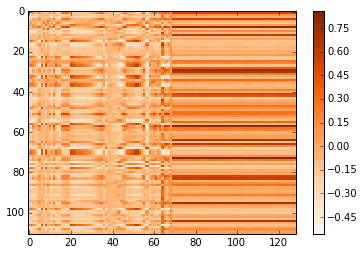

In [42]:
matrix=correlations.as_matrix()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
#plt.imshow(matrix.astype(np.float32))
plt.imshow(matrix.astype(np.float32), interpolation='nearest', cmap=plt.cm.Oranges, 
          aspect='auto') 
plt.colorbar()
plt.show()

This plot shows how high the coefficients are in the matrix (the horizontal axis represents the regressors, while the vertical axis represents the different type of calls). It can be seen that on the right half of the plot the colors are darker in opposite to the light colors of the other half. 

The right half belongs to the regressors associated with working population, while the left half shows the coefficients for the resident population

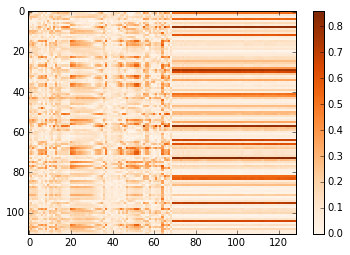

In [43]:
matrix=np.abs(correlations.as_matrix())
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
#plt.imshow(matrix.astype(np.float32))
plt.imshow(matrix.astype(np.float32), interpolation='nearest', cmap=plt.cm.Oranges, 
          aspect='auto') 
plt.colorbar()
plt.show()

This plot is similar to the previous one, however this one shows the absolute value of the coefficients. It still can be seen that for some types of complains, the colors in the right half (working population demographics) are darker which in this case says that the correlations between demographic indicators of the working population and types of complains per capita are stronger than the resident demographics

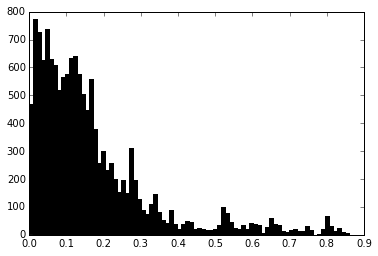

In [49]:
matrix=np.abs(correlations.as_matrix())
matrix_t=matrix.astype(np.float32)
A=plt.hist(matrix_t.ravel(), bins=80, fc='k', ec='k')

Histogram that represents the behavior of the absolute values of the correlation coefficients between all the demographic attributes and all the types of complains. Most of the coefficients' absolute values are between 0.0 and 0.1. However, there are a considerable number of coefficients that are higher than those

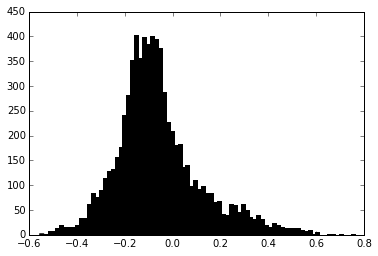

In [50]:
resident_attributes_corr=correlations[residents_demographics]
matrix_residents=resident_attributes_corr.as_matrix()
matrix_residents_t=matrix_residents.astype(np.float32)
A=plt.hist(matrix_residents_t.ravel(), bins=80, fc='k', ec='k')

Histogram that represents the behavior of the correlation coefficients between the demographic attributes of the RESIDENTS and all the types of complains. The coefficients seem to be normally distributed but notoriously skewed towards the negative side

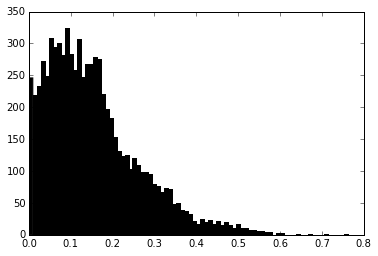

In [51]:
resident_attributes_corr=correlations[residents_demographics]
matrix_residents=np.abs(resident_attributes_corr).as_matrix()
matrix_residents_t=matrix_residents.astype(np.float32)
A=plt.hist(matrix_residents_t.ravel(), bins=80, fc='k', ec='k')

Histogram that represents the behavior of the ABSOLUTE VALUES of the correlation coefficients between the demographic attributes of the RESIDENTS and all the types of complains.

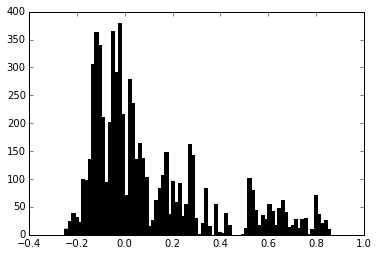

In [52]:
workers_attributes_corr=correlations[workers_demographics]
matrix_workers=workers_attributes_corr.as_matrix()
matrix_workers_t=matrix_workers.astype(np.float32)
A=plt.hist(matrix_workers_t.ravel(), bins=80, fc='k', ec='k')

Histogram that represents the behavior of the correlation coefficients between the demographic attributes of the WORKERS and all the types of complains. The coefficients seem to be greater compared to the ones obtained for the resident demographics

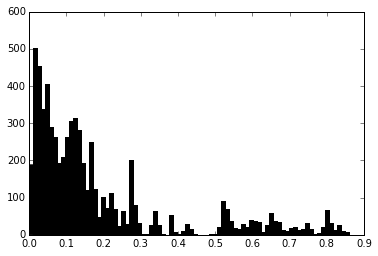

In [53]:
workers_attributes_corr=correlations[workers_demographics]
matrix_workers=np.abs(workers_attributes_corr).as_matrix()
matrix_workers_t=matrix_workers.astype(np.float32)
A=plt.hist(matrix_workers_t.ravel(), bins=80, fc='k', ec='k')

Histogram that represents the behavior of the absolute values of the correlation coefficients between the demographic attributes of the WORKERS and all the types of complains. The coefficients seem to be greater compared to the ones obtained for the resident demographics